# **Table of Contents**
1) Imports
2) Loading the Dataset and Creating of DataFrame
3) Labelling the classes and plot the Classification Graph

**Importing various Libraries**

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

**Loading the Dataset , creating a Data Frame which includes labels and saving it to a CSV file** 

In [2]:
# Define dataset path
dataset_path = "/kaggle/input/dataset/DATASET"  

# Initialize lists
image_paths = []
labels = []

# Iterate through main categories (Biodegradable, Nonbiodegradable,Recyclable)
for category in ["Biodegradable", "Nonbiodegradable","Recyclable"]:
    category_path = os.path.join(dataset_path, category)
    
    if os.path.isdir(category_path):  # Ensure it's a directory
        for subcategory in os.listdir(category_path):  # Iterate through subcategories
            subcategory_path = os.path.join(category_path, subcategory)

            if os.path.isdir(subcategory_path):  # Ensure it's a directory
                for image_name in os.listdir(subcategory_path):
                    if image_name.endswith((".png", ".jpg", ".jpeg")):  # Filter image files
                        image_paths.append(os.path.join(category, subcategory, image_name))  # Store relative path
                        labels.append(category)  # Assign main category as label

# Create DataFrame
df = pd.DataFrame({"image_path": image_paths, "label": labels})

# Save to CSV
csv_path = "/kaggle/working/dataset_labels.csv"
df.to_csv(csv_path, index=False)

print(f"Dataset labels saved to {csv_path}")


Dataset labels saved to /kaggle/working/dataset_labels.csv


**Display the Classified Dataframe**

In [3]:
df = pd.read_csv("/kaggle/working/dataset_labels.csv")
print(df.head())

                                          image_path          label
0              Biodegradable/leaf_waste/00000042.jpg  Biodegradable
1              Biodegradable/leaf_waste/00000080.jpg  Biodegradable
2              Biodegradable/leaf_waste/00000113.jpg  Biodegradable
3  Biodegradable/leaf_waste/a6876e29-dc0f-4716-bd...  Biodegradable
4              Biodegradable/leaf_waste/00000115.jpg  Biodegradable


In [4]:
dff=pd.DataFrame(df)
dff.tail()

,image_path,label
31069,Recyclable/paper_cups/Image_60.png,Recyclable
31070,Recyclable/paper_cups/Image_132.png,Recyclable
31071,Recyclable/paper_cups/Image_4 (2).png,Recyclable
31072,Recyclable/paper_cups/Image_165.png,Recyclable
31073,Recyclable/paper_cups/Image_27 (2).png,Recyclable



**Plotting a Bar Graph which displays how many images belong to a Specific class.The classes are Biodegradable,Non Biodegradable and Recyclable**


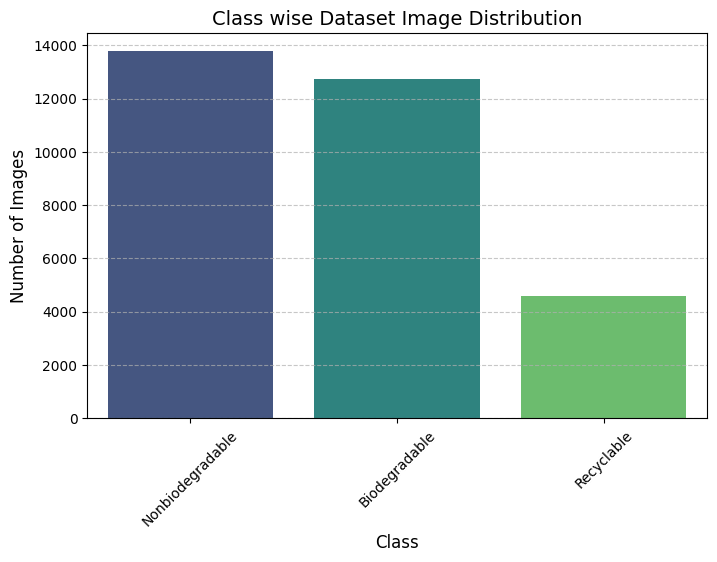

In [6]:
# Load dataset labels CSV
csv_path = "/kaggle/working/dataset_labels.csv"  
df = pd.read_csv(csv_path)

# Count images per class
class_counts = df["label"].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")

# Add labels
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Class wise Dataset Image Distribution", fontsize=14)
plt.xticks(rotation=45)  # Rotate labels if needed
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()


In [7]:
df.shape

(31074, 2)

In [9]:
df = pd.read_csv("/kaggle/working/dataset_labels.csv")
print(df["label"].value_counts()) 

label
Nonbiodegradable    13774
Biodegradable       12728
Recyclable           4572
Name: count, dtype: int64


**Augmenting the Dataset**

In [8]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

# Load dataset
csv_path = "/kaggle/input/labels/dataset_labels.csv"  
df = pd.read_csv(csv_path)

# Filter only Recyclable images
recyclable_df = df[df["label"] == "Recyclable"]

# Define paths
dataset_dir = "/kaggle/input/dataset/DATASET" 
augmented_dir = "/kaggle/working/augmented_recyclable"  # Folder to save augmented images

# Ensure the base augmentation directory exists
os.makedirs(augmented_dir, exist_ok=True)

# Image augmentation settings
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

AUGMENTATIONS_PER_IMAGE = 2  # Adjust based on how many images you need -> size=size+(2*size)

new_image_paths = []

# Loop through each recyclable image and generate augmented versions
for _, row in tqdm(recyclable_df.iterrows(), total=len(recyclable_df)):
    img_path = os.path.join(dataset_dir, row["image_path"])

    # Check if image file exists
    if not os.path.exists(img_path):
        print(f"Skipping missing file: {img_path}")
        continue  # Skip to the next image

    try:
        img = load_img(img_path)  # Load image
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        continue  # Skip corrupted images

    img_array = img_to_array(img)  # Convert to NumPy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Extract subfolder path
    subfolder = os.path.dirname(row["image_path"])
    save_subdir = os.path.join(augmented_dir, subfolder)  # Path to save augmented images

    # Ensure subdirectory exists
    os.makedirs(save_subdir, exist_ok=True)

    # Generate augmented images
    i = 0
    for batch in datagen.flow(img_array, batch_size=1):
        aug_img_name = f"aug_{i}_{os.path.basename(row['image_path'])}"
        aug_img_path = os.path.join(save_subdir, aug_img_name) 
        
        array_to_img(batch[0]).save(aug_img_path)  # Save augmented image
        new_image_paths.append([aug_img_path, "Recyclable"])  # Store new image path
        
        i += 1
        if i >= AUGMENTATIONS_PER_IMAGE:
            break  # Stop after required augmentations

# Convert new images to DataFrame
new_df = pd.DataFrame(new_image_paths, columns=["image_path", "label"])

# Append to original dataset
df = pd.concat([df, new_df], ignore_index=True)

# Save updated dataset CSV
augmented_csv_path = "/kaggle/working/dataset_labels_augmented2.csv"
df.to_csv(augmented_csv_path, index=False)

print(f"✅ Dataset augmentation complete! New CSV saved at {augmented_csv_path}")


100%|██████████| 4572/4572 [05:43<00:00, 13.32it/s] 


✅ Dataset augmentation complete! New CSV saved at /kaggle/working/dataset_labels_augmented2.csv


**Creating New CSV**


In [10]:
# Define dataset path
dataset_path = "/kaggle/input/augmenteddataset/DATASET"  

# Initialize lists
image_paths = []
labels = []

# Iterate through main categories (Biodegradable, Nonbiodegradable)
for category in ["Biodegradable", "Nonbiodegradable","Recyclable"]:
    category_path = os.path.join(dataset_path, category)
    
    if os.path.isdir(category_path):  # Ensure it's a directory
        for subcategory in os.listdir(category_path):  # Iterate through subcategories
            subcategory_path = os.path.join(category_path, subcategory)

            if os.path.isdir(subcategory_path):  # Ensure it's a directory
                for image_name in os.listdir(subcategory_path):
                    if image_name.endswith((".png", ".jpg", ".jpeg")):  # Filter image files
                        image_paths.append(os.path.join(category, subcategory, image_name))  # Store relative path
                        labels.append(category)  # Assign main category as label

# Create DataFrame
df = pd.DataFrame({"image_path": image_paths, "label": labels})

# Save to CSV
csv_path = "/kaggle/working/dataset_label2.csv"
df.to_csv(csv_path, index=False)

print(f"Dataset labels saved to {csv_path}")


Dataset labels saved to /kaggle/working/dataset_label2.csv


In [ ]:
import shutil
import os

# Define path to the augmented dataset
augmented_dir = "/kaggle/working/augmented_recyclable"
zip_path = "/kaggle/working/augmented_recyclable.zip"

# Ensure the directory exists before zipping
if os.path.exists(augmented_dir):
    # Zip the folder
    shutil.make_archive(augmented_dir, 'zip', augmented_dir)
    print(f"✅ Augmented dataset zipped at {zip_path}")
else:
    print("⚠️ Augmented dataset not found. Please check if the augmentation script ran successfully.")


**Display the Augmented Data**

In [11]:
df = pd.read_csv("/kaggle/input/augmented/dataset_label2.csv")
print(df["label"].value_counts()) 

label
Nonbiodegradable    13774
Recyclable          13716
Biodegradable       12728
Name: count, dtype: int64


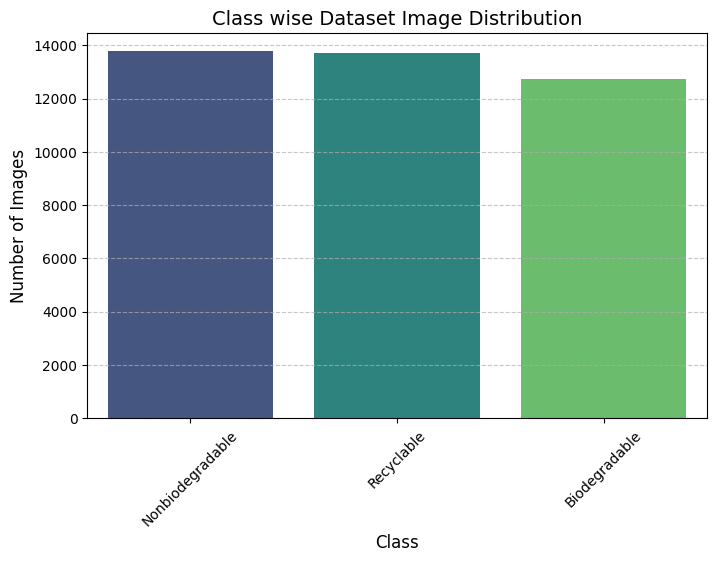

In [10]:
# Load dataset labels CSV
csv_path = "/kaggle/input/augmented/dataset_label2.csv"  
df = pd.read_csv(csv_path)

# Count images per class
class_counts = df["label"].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")

# Add labels
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Class wise Dataset Image Distribution", fontsize=14)
plt.xticks(rotation=45)  # Rotate labels if needed
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()


**Appending Image Paths in CSV to start with /kaggle/input**

In [14]:
import pandas as pd
import os

# Load CSV
csv_path = "/kaggle/input/augmented/dataset_label2.csv"  
df = pd.read_csv(csv_path)

# Fix image paths by adding the full directory
dataset_dir = "/kaggle/input/augmenteddataset/DATASET" 
df["image_path"] = df["image_path"].apply(lambda x: os.path.join(dataset_dir, x))
# df["image_path"] = "/kaggle/input/your_dataset_folder/" + df["image_path"] 

# Checking if files exist now
missing_files = df[~df["image_path"].apply(os.path.exists)]
print(f"Missing {len(missing_files)} files after path correction")

# Saved the corrected CSV for later use
df.to_csv("/kaggle/working/fixed_dataset.csv", index=False)

print("Image paths fixed!")


Missing 0 files after path correction
Image paths fixed!


**Resizing to 224,224 , Shuffling to 80% Training , 20% Validation**

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import ImageFile, Image
import numpy as np
import os

#for truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

#Fix for transparency issue in some images
def preprocess_image(image_path):
    try:
        img = Image.open(image_path)
        if img.mode == "P":  # Convert palette images with transparency
            img = img.convert("RGBA").convert("RGB")
        return img
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return None

# Define constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10

DATASET_PATH = "/kaggle/input/augmenteddataset/DATASET"  

#Data Preprocessing & Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 80% Train, 20% Validation
)

#Load training and validation sets
train_ds = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    subset="training"
)

val_ds = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    subset="validation"
)

Found 33609 images belonging to 3 classes.
Found 8400 images belonging to 3 classes.


**Loading RestNet50 CNN model and Starting the Training**

In [14]:
#Load pre-trained ResNet50 (without top layers)
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze pre-trained layers

#Build the new model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(3, activation="softmax")  # 3 classes: Biodegradable, Nonbiodegradable, Recyclable
])

#Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

#Define callbacks (early stopping & model checkpoint)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "/kaggle/working/best_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

#Train the model
print("Training started...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping, checkpoint]
)

#Evaluate model
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

#Save final trained model
MODEL_PATH = "/kaggle/working/model_final.keras"
model.save(MODEL_PATH)
print(f"Model saved successfully at {MODEL_PATH}!")


Training started...
Epoch 1/10
 182/1051 ━━━━━━━━━━━━━━━━━━━━ 8:31 589ms/step - accuracy: 0.3809 - loss: 1.2024

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.4361 - loss: 1.0860
Epoch 1: val_accuracy improved from -inf to 0.47738, saving model to /kaggle/working/best_model.keras
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 810s 759ms/step - accuracy: 0.4361 - loss: 1.0860 - val_accuracy: 0.4774 - val_loss: 1.0730
Epoch 2/10
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.5291 - loss: 0.9658
Epoch 2: val_accuracy did not improve from 0.47738
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 544s 515ms/step - accuracy: 0.5291 - loss: 0.9658 - val_accuracy: 0.3645 - val_loss: 1.2406
Epoch 3/10
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.5580 - loss: 0.9201
Epoch 3: val_accuracy did not improve from 0.47738
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 545s 515ms/step - accuracy: 0.5580 - loss: 0.9201 - val_accuracy: 0.4195 - val_loss: 1.1439
Epoch 4/10
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.5814 - loss: 0.8973
Epoch 4: val_accuracy improved from 0.47738 to 0.53060, saving model to /kaggl

**Testing on a Random Image -> Trying to Predict its Class**

In [19]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the trained model
model = tf.keras.models.load_model("/kaggle/working/model_final.keras")

# Function to preprocess and predict an image
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize image
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)  # Get class index

    class_labels = ["Biodegradable", "Nonbiodegradable", "Recyclable"] 
    return class_labels[predicted_class]

# Example usage
img_path = "/kaggle/input/testing3/laef.jpg"  
prediction = predict_image(img_path)
print(f"Predicted Category: {prediction}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Category: Biodegradable
